# Lithology Modeling with Amazon SageMaker XGBoost algorithm
_**Single machine training for regression with Amazon SageMaker XGBoost algorithm**_

---

---
## Contents
1. [Introduction](#Introduction)
2. [Setup](#Setup)
  1. [Define Some Functions](#Define-Some-Functions)
  2. [Data Ingestion](#Data-ingestion)
3. [Training and deploying the XGBoost model](#Training-and-deploying-the-XGBoost-model)
4. [Make Prediction Using Your Model](#Make-Prediction-Using-Your-Model)

---
## Introduction


This notebook demonstrates the use of Amazon SageMaker's implementation of the XGBoost algorithm to train and host a classification model for prediction of lithology from well log measurements. 

> A Jupyter Notebook is an open-source web application that allows you to create and share documents that contain live code, equations, visualizations and narrative text. - http://jupyter.org/

The dataset is log data from nine wells, with 5 wireline log measurements, two indicator variables and a facies label at half foot intervals. The seven predictor variables are:

Five wireline log curves including: 

- Gamma ray (GR)
- Resistivity logging (ILD_log10)
- Photoelectric effect (PE) - Note, some wells do not have PE.
- Neutron-density porosity difference 
- Average neutron-density porosity (DeltaPHI and PHIND)

Two geologic constraining variables: 

- Nonmarine-marine indicator (NM_M) 
- Relative position (RELPOS)
- Facies

We will focus on these logs: GR, ILD_log10, DeltaPH, PHIND, where we try to predict Facies by training using 7 wells, 1 validation well, and one well for blind test. 

The dataset comes from a class exercise from The University of Kansas on Neural Networks and Fuzzy Systems. This exercise is based on a consortium project to use machine learning techniques to create a reservoir model of the largest gas fields in North America, the Hugoton and Panoma Fields. For more info on the origin of the data, see Bohling and Dubois (2003) and Dubois et al. (2007).

---
## Setup


Let's start by loading the required libraries to run the notebook: 

In [30]:
%%time
import os
import boto3
import re
import sagemaker
from sagemaker import get_execution_role
from sagemaker.predictor import csv_serializer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pandas import set_option
import struct
import io
import random
from numpy  import array
import pickle, gzip, urllib.request, json
%matplotlib inline

role = get_execution_role()
region = boto3.Session().region_name

CPU times: user 132 ms, sys: 4.68 ms, total: 136 ms
Wall time: 172 ms


### Define some functions

Following methods (data_split) split the data into train/test/validation datasets and upload files to S3. Also we define functions for displaying our results (compare_facies_plot) and doing prediction on blind well (predict).

In [31]:
def data_split(FILE_DATA, FILE_TRAIN, FILE_VALIDATION, FILE_TEST, Valid_Well_Name, Blind_Well_Name, TARGET_VAR):
    data = pd.read_csv(FILE_DATA)
    n = data.shape[0]
    
    # Make the first column the target feature    
    cols = data.columns.tolist()
    target_pos = data.columns.get_loc(TARGET_VAR)
    cols.pop(target_pos)
    cols = [TARGET_VAR] + cols
    data = data.loc[:,cols]
                
    # Remove target colun from test set
    #test_data = test_data.drop([TARGET_VAR], axis=1)

    # Split data
    test_data = data[data['Well Name'] == Blind_Well_Name]
    test_data = test_data.drop(['Well Name'], axis=1)
    
    valid_data = data[data['Well Name'] == Valid_Well_Name]
    valid_data = valid_data.drop(['Well Name'], axis=1)

    train_data = data[data['Well Name'] != Blind_Well_Name]
    train_data = train_data[train_data['Well Name'] != Valid_Well_Name]

    train_data = train_data.drop(['Well Name'], axis=1)

    train_data.to_csv(FILE_TRAIN, index=False, header=False)
    valid_data.to_csv(FILE_VALIDATION, index=False, header=False)
    test_data.to_csv(FILE_TEST, index=False, header=False)
    
def write_to_s3(fobj, bucket, key):
    return boto3.Session().resource('s3').Bucket(bucket).Object(key).upload_fileobj(fobj)

def upload_to_s3(bucket, channel, filename):
    fobj=open(filename, 'rb')
    key = prefix+'/'+channel+'/'+filename
    url = 's3://{}/{}'.format(bucket, key)
    print('Writing to {}'.format(url))
    write_to_s3(fobj, bucket, key)     
    return(url)


In [32]:
def compare_facies_plot(logs, compadre, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster1 = np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(logs[compadre].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(9, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    im1 = ax[4].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    im2 = ax[5].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im2, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel('Facies')
    ax[5].set_xlabel(compadre)    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([])
    ax[4].set_xticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

In [33]:
def predict(data):
    rows=len(data)
    xgboost_predictor.content_type = 'text/csv'
    xgboost_predictor.serializer = csv_serializer
    xgboost_predictor.deserializer = None

    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgboost_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

We will specify the S3 bucket and prefix that you want to use for storing training/validation data. This should be within the same region as the Notebook Instance, training, and hosting.

**<span style="color:blue">1- Set you bucket name, by assigning your bucket name to a variable named "bucket". You can leave other lines unchanged:</span>**

In [34]:
bucket='your bucket name' # put your s3 bucket name here, and create s3 bucket
prefix = 'public-data'
bucket_path = 'https://s3-{}.amazonaws.com/{}'.format(region,bucket)

### Data ingestion

Next, we read the dataset from the data.csv file that you downloaded earlier. This file needs to be uploaded to the Sagemaker notebook instance.

When using the csv option, here is the critical piece of information about the data format:

> For CSV training, the algorithm assumes that the target variable is in the first column and that the CSV does not have a header record. For CSV inference, the algorithm assumes that CSV input does not have the label column.

[Source](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html)

**<span style="color:blue">2- Read data.csv:</span>**



In [35]:
data = pd.read_csv('data.csv')

**<span style="color:blue">3- Remove rows with missing data</span>**



In [36]:
# Remove rows with missing values
data.dropna(inplace=True)

In [37]:
data['Facies'] = data['Facies']-1  # we need to subtract 1 to make class ranges start from 0 (required by Sagemaker's xgb algo)

**<span style="color:blue">4- Print the first few rows, and also the names of all of the wells in the dataset for qc</span>**



In [38]:
print(data.head())
print(data['Well Name'].unique())

   Facies  Well Name   Depth     GR  ILD_log10  DeltaPHI   PHIND  RELPOS
0       2  SHRIMPLIN  2793.0  77.45      0.664       9.9  11.915   1.000
1       2  SHRIMPLIN  2793.5  78.26      0.661      14.2  12.565   0.979
2       2  SHRIMPLIN  2794.0  79.05      0.658      14.8  13.050   0.957
3       2  SHRIMPLIN  2794.5  86.10      0.655      13.9  13.115   0.936
4       2  SHRIMPLIN  2795.0  74.58      0.647      13.5  13.300   0.915
['SHRIMPLIN' 'ALEXANDER D' 'SHANKLE' 'LUKE G U' 'KIMZEY A'
 'CROSS H CATTLE' 'NOLAN' 'Recruit F9' 'NEWBY' 'CHURCHMAN BIBLE']


In [39]:
################# ADD FACIES LABELS ##################

# 1=sandstone  2=c_siltstone   3=f_siltstone 
# 4=marine_silt_shale 5=mudstone 6=wackestone 7=dolomite
# 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]

data.loc[:,'FaciesLabels'] = data.apply(lambda row: label_facies(row, facies_labels), axis=1)     

**<span style="color:blue">5- Only select the following columns from your data:
    'Well Name', 'Facies','GR', 'DeltaPHI', 'PHIND'</span>**



In [40]:
data = data.loc[:,['Well Name', 'Facies','GR', 'DeltaPHI', 'PHIND']]
print(data.head())

   Well Name  Facies     GR  DeltaPHI   PHIND
0  SHRIMPLIN       2  77.45       9.9  11.915
1  SHRIMPLIN       2  78.26      14.2  12.565
2  SHRIMPLIN       2  79.05      14.8  13.050
3  SHRIMPLIN       2  86.10      13.9  13.115
4  SHRIMPLIN       2  74.58      13.5  13.300


**<span style="color:blue">6- Write file back to disk as data_clean.csv</span>**



In [41]:
data.to_csv('data_clean.csv', index=False)

In [42]:
FILE_DATA = 'data_clean.csv'
TARGET_VAR = 'Facies'
FILE_TRAIN = 'facies_train.csv'
FILE_VALIDATION = 'facies_validation.csv'
FILE_TEST = 'facies_test.csv'
Valid_Well_Name = 'SHRIMPLIN'
Blind_Well_Name = 'SHANKLE'

data_split(FILE_DATA, FILE_TRAIN, FILE_VALIDATION, FILE_TEST, Valid_Well_Name, Blind_Well_Name, TARGET_VAR)

In [43]:
# upload the files to the S3 bucket
s3_train_loc = upload_to_s3(bucket = bucket, channel = 'train', filename = FILE_TRAIN)
s3_valid_loc = upload_to_s3(bucket = bucket, channel = 'validation', filename = FILE_VALIDATION)
s3_test_loc = upload_to_s3(bucket = bucket, channel = 'test', filename = FILE_TEST)

Writing to s3://osdu-test/public-data/train/facies_train.csv
Writing to s3://osdu-test/public-data/validation/facies_validation.csv
Writing to s3://osdu-test/public-data/test/facies_test.csv


## Training and deploying the XGBoost model

After setting training parameters, we kick off training, and poll for status until training is completed, which in this example, takes between 5 and 6 minutes.

XGBoost hyperparameter [docs](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html).

In [46]:
from sagemaker.amazon.amazon_estimator import get_image_uri 
container = get_image_uri(boto3.Session().region_name,
                          'xgboost', 
                          repo_version='0.90-1'); 
xgboost = sagemaker.estimator.Estimator(container,
                                       role, 
                                       train_instance_count=1, 
                                       train_instance_type='ml.c4.xlarge',
                                       output_path='s3://{}/{}/output'.format(bucket, prefix),
                                       sagemaker_session=sagemaker.Session())

# Set the hyperparameters
xgboost.set_hyperparameters(max_depth=3,
                        eta=0.2,
                        colsample_bytree=0.9,
                        gamma=.8,
                        min_child_weight=10,
                        num_class = len(facies_labels),
                        subsample=0.8,
                        num_round = 100,
                        objective='multi:softmax')

# Set the input data formatting and locatiopns
s3_input_train = sagemaker.s3_input(s3_data=s3_train_loc, content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data=s3_valid_loc, content_type='csv')

**<span style="color:blue">7- Train the model</span>**

In [47]:
xgboost.fit({'train': s3_input_train, 'validation': s3_input_validation})

2019-11-22 23:36:25 Starting - Starting the training job...
2019-11-22 23:36:26 Starting - Launching requested ML instances......
2019-11-22 23:37:30 Starting - Preparing the instances for training......
2019-11-22 23:38:38 Downloading - Downloading input data
2019-11-22 23:38:38 Training - Downloading the training image...
2019-11-22 23:39:17 Uploading - Uploading generated training model
2019-11-22 23:39:17 Completed - Training job completed
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value multi:softmax to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[23:39:09] 3229x3 matrix with 9687 

Training seconds: 50
Billable seconds: 50


**<span style="color:blue">8- Deploy the model</span>**

In [48]:
xgboost_predictor = xgboost.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

---------------------------------------------------------------------------------------------------------------!

## Make Prediction Using Your Model
Finally, the customer can now validate the model for use. They can obtain the endpoint from the client library using the result from previous operations, and generate classifications from the trained model using that endpoint.


In [49]:
test_data = pd.read_csv(FILE_TEST, header=None)
labels = data.iloc[:,0]  # labels data
predictions = predict(test_data.as_matrix()[:, 1:])+1. # Note that we are not using the first column, which is the label

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


In [50]:
data = pd.read_csv('data.csv')
Blindwell = data[data['Well Name'] == Blind_Well_Name]
Blindwell['Pred_Facies'] = predictions

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


**<span style="color:blue">9- Display your results</span>**

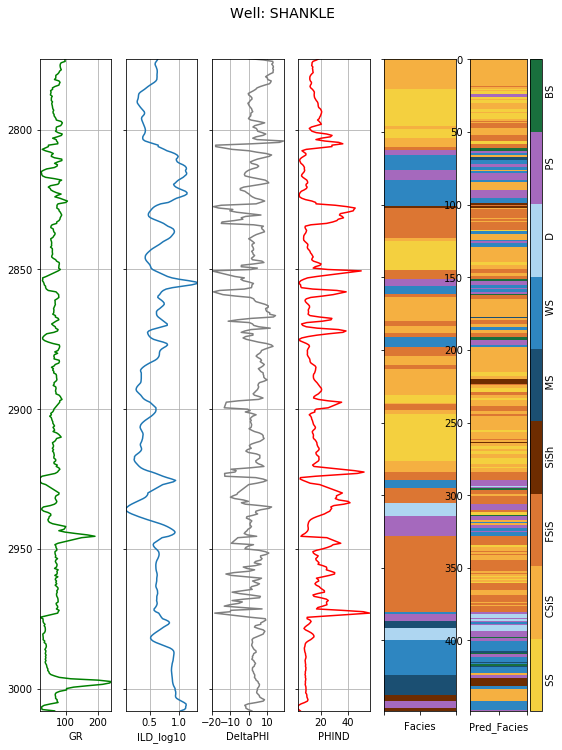

In [51]:
compare_facies_plot(Blindwell, 'Pred_Facies', facies_colors)

### (Optional) Delete the Endpoint
If you're ready to be done with this notebook, make sure run the cell below.  This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [ ]:
# print(xgboost_predictor.endpoint)

# import sagemaker
# sagemaker.Session().delete_endpoint(xgboost_predictor.endpoint)